# Describing the Provided Solver: `ChunkDomain`

This notebook provides an overview on the provided `ChunkDomain` solver.

In [1]:
import matplotlib.pyplot as plt
from _plot_domain import plot_dense_domain

from parallel_heat.chunk_domain import ChunkDomain, DomainLink
from parallel_heat.domain import ProblemParamaters, Side


Neither `DenseDomain`s nor `ChunkDomain`s have a specific location they are anchored to. Instead, when doing a domain decomposition, we provide relative locations based on which edges of which domains are connected together.

Below, we stack a domain indexed 1 on top of one indexed zero. We can plot them together:

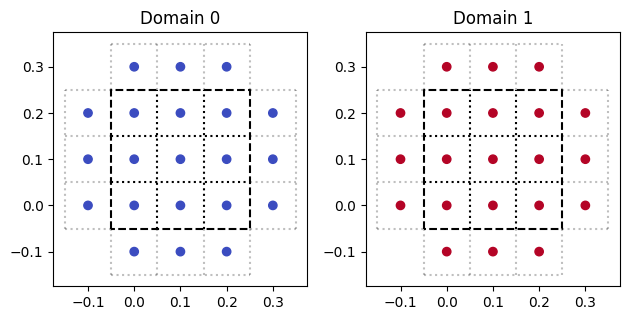

In [2]:
domain = ChunkDomain(
    [(0, 3, 3), (1, 3, 3)],
    [DomainLink(domain_a=0, side_a=Side.TOP, domain_b=1, side_b=Side.BOTTOM)],
    parameters=ProblemParamaters(dx=0.1, dy=0.1, dt=0.001, diffusivity=0.5),
)

domain.subdomains[0].field[...] = 0
for side in Side:
    domain.subdomains[0].get_edge_exterior(side)[...] = 0

domain.subdomains[1].field[...] = 1
for side in Side:
    domain.subdomains[1].get_edge_exterior(side)[...] = 1

fig, axs = plt.subplots(nrows=1, ncols=2)
for idomain in range(2):
    plt.sca(axs[idomain])
    plot_dense_domain(domain.subdomains[idomain], vmin=0, vmax=1)
    plt.title(f"Domain {idomain}")


fig.tight_layout()
plt.show()

Domain 1 is on top of domain 0, so stepping the simulation, we would expect that the bottom of domain 1 receives the cool field of domain 0. Indeed:

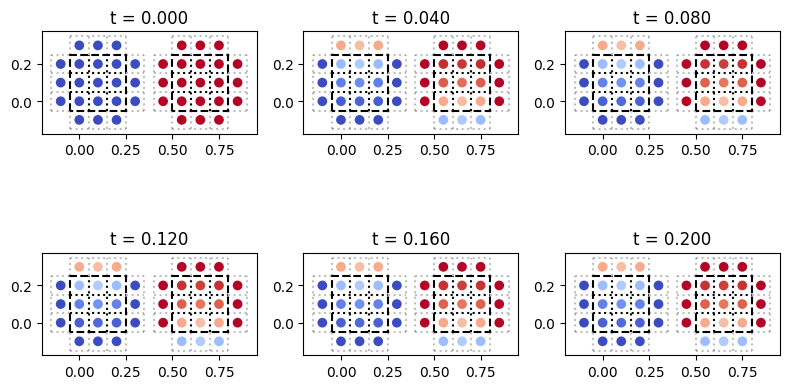

In [3]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8, 5))
t = 0
for ax in axs.flatten():
    # -=-   plot   -=-
    plt.sca(ax)
    for i in range(2):
        plot_dense_domain(
            domain.subdomains[i],
            vmin=0,
            vmax=1,
            include_ghost_cells=True,
            x_offset=i*0.55
        )
    plt.title(f"t = {t:.3f}")
    # -=- end plot -=-

    for _ in range(40):
        # -=-   update   -=-
        t += domain.problem_parameters.dt
        domain.step()
        # -=- end update -=-

fig.tight_layout()
plt.show()

The `step` method in `ChunkDomain` first sets the ghost cell values to the edge values on the other side.

```python
    def step(self):
        for link in self.interior_links:
            link.direct_transfer(
                self.subdomains[link.domain_a], self.subdomains[link.domain_b]
            )

        for domain in self.subdomains.values():
            domain.step()
```

Since `link.direct_transfer` directly sets the values in the arrays, you will need to use something different for `DistributedDomain`.